In [4]:
import pandas as pd
import os, sys
import numpy as np
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root_path not in sys.path:
    sys.path.append(project_root_path)

from src.utils import load_dataset
from src.utils import show_mnist

## 1. Load dataset

In [6]:
DATA_DIR = '../data'
dataset = load_dataset(DATA_DIR)

To access image and label of the i-th observation, use

In [7]:
i = 0
print(dataset[0][i].shape)
print(dataset[1][i].shape)

(28, 28)
()


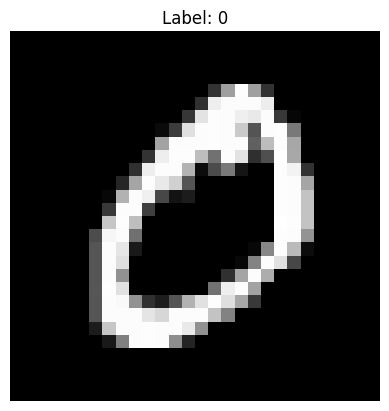

In [8]:
show_mnist(dataset[0][1], dataset[1][1])

## 4. Build Convolutional Neural Network

### 4.1. Convolutional Neural Layer

In [ ]:
def do_cnn_layer(image, kernel = None):
    '''
    Thực hiện phép tích chập 2D đơn giản trên một ảnh.
    '''
    N = image.shape[0]
    new_image = np.zeros((N, N))
    if kernel is None:
        kernel = np.array([
            [1,  1,  1],
            [1, -8,  1],
            [1,  1,  1]
        ])

    for i in range(1, N - 1):
        for j in range(1, N - 1):
            image_patch = image[i-1:i+2, j-1:j+2]
            new_pixel_value = np.sum(image_patch * kernel)
            new_image[i, j] = new_pixel_value
    
    return new_image

### 4.2. Pooling Layer

In [ ]:
def max_pooling_layer(feature_map, pool_size=2, stride=2):
    """
    Thực hiện Max Pooling trên một bản đồ đặc trưng (feature map).
    
    Args:
        feature_map (np.array): Ma trận đầu vào (kết quả từ lớp CNN).
        pool_size (int): Kích thước của cửa sổ pooling (ví dụ: 2 nghĩa là 2x2).
        stride (int): Bước nhảy của cửa sổ.
        
    Returns:
        np.array: Ma trận đầu ra đã được giảm kích thước.
    """
    input_height, input_width = feature_map.shape
    
    # Tính toán kích thước của ma trận đầu ra
    output_height = (input_height - pool_size) // stride + 1
    output_width = (input_width - pool_size) // stride + 1
    
    # Tạo ma trận đầu ra với các giá trị 0
    pooled_map = np.zeros((output_height, output_width))
    
    # Bắt đầu trượt cửa sổ qua ma trận đầu vào
    for i in range(output_height):
        for j in range(output_width):
            # Xác định vị trí của cửa sổ hiện tại
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + pool_size
            end_j = start_j + pool_size
            
            # Cắt ra cửa sổ từ feature map
            window = feature_map[start_i:end_i, start_j:end_j]
            
            # Lấy giá trị lớn nhất trong cửa sổ và gán vào ma trận đầu ra
            pooled_map[i, j] = np.max(window)
            
    return pooled_map

### 4.3. Demo logic

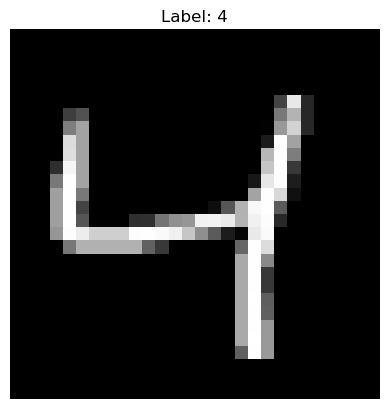

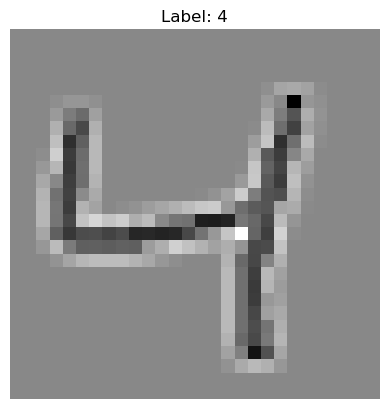

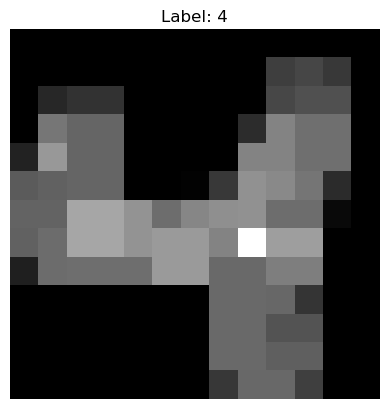

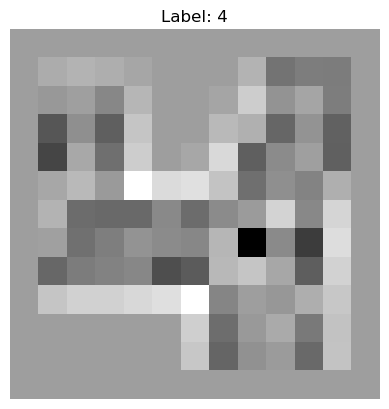

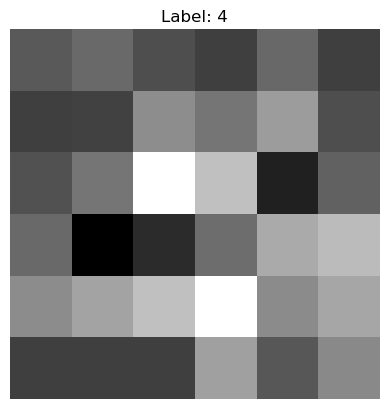

In [ ]:
ord = 2

images = [dataset[0][ord] for i in range(5)]
images[1] = do_cnn_layer(images[0])
images[2] = max_pooling_layer(images[1], pool_size=3, stride=2) * 1e9 * 1e9 
images[3] = do_cnn_layer(images[2])
images[4] = max_pooling_layer(images[3])

for i in range(5):
    show_mnist(images[i], dataset[1][ord])

### 4.4. Full logic

See more at `lesson-01/src/ANN/CNN.py`.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import mlflow
import mlflow.pytorch
from src.ANN.CNN import CNN

In [11]:
# --- 1. Thiết lập các tham số (Hyperparameters) ---
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 5
MLFLOW_EXPERIMENT_NAME = "MNIST_Classification"

In [ ]:
def train(train_dataset):
    """
    Hàm chính để thực hiện toàn bộ quá trình training và tracking với MLflow.
    """
    # --- 2. Chuẩn bị dữ liệu ---
    print("Đang tải và chuẩn bị dữ liệu...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Chuẩn hóa dữ liệu MNIST với mean và std đã biết
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Tải training và validation dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Tạo DataLoaders để cung cấp dữ liệu theo từng batch
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Tải dữ liệu thành công!")

    # --- 3. Bắt đầu phiên làm việc với MLflow ---
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    with mlflow.start_run() as run:
        print(f"Bắt đầu MLflow run: {run.info.run_id}")
        
        # Log các tham số
        mlflow.log_param("learning_rate", LEARNING_RATE)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("epochs", EPOCHS)
        mlflow.log_param("model_class", "SimpleCNN")

        # --- 4. Khởi tạo model, optimizer và loss function ---
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = CNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.CrossEntropyLoss()

        # --- 5. Vòng lặp Training & Validation ---
        for epoch in range(EPOCHS):
            # Chuyển model sang chế độ train
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                output = model(data)
                
                # Calculate loss
                loss = loss_fn(output, target)
                
                # Backward pass
                loss.backward()
                
                # Update weights
                optimizer.step()

            # --- Validation sau mỗi epoch ---
            model.eval() # Chuyển model sang chế độ đánh giá
            val_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += loss_fn(output, target).item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = 100. * correct / len(val_loader.dataset)
            
            print(f"Epoch {epoch+1}/{EPOCHS} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            
            # Log các chỉ số vào MLflow
            mlflow.log_metric("validation_loss", val_loss, step=epoch)
            mlflow.log_metric("validation_accuracy", val_accuracy, step=epoch)

        # --- 6. Log model đã huấn luyện vào MLflow ---
        print("Training hoàn tất. Đang lưu model vào MLflow...")
        mlflow.pytorch.log_model(model, "model")
        print("Lưu model thành công!")

def main():
    # Cài đặt MLflow nếu chưa có
    try:
        import mlflow
    except ImportError:
        print("Đang cài đặt mlflow...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
    
    train()
    print("\nHoàn tất! Để xem kết quả, mở terminal và chạy lệnh: mlflow ui")
    print("Sau đó truy cập http://127.0.0.1:5000 trong trình duyệt.")
